# Воркшоп: agentic reasoning на langgraph
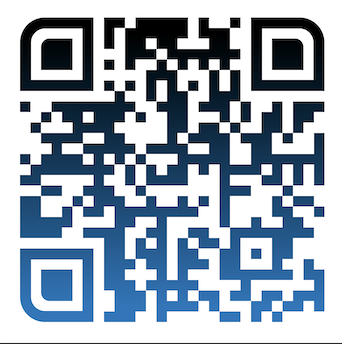

https://github.com/Rai220/workshops

In [ ]:
# !pip install langchain langchain_gigachat langchain_community langgraph langchain_chroma langchain_openai tavily-python rich python-dotenv nest_asyncio pyppeteer -q

In [3]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langgraph.graph import END, START, MessagesState, StateGraph
from typing import List
from langgraph.types import Command
from pydantic import BaseModel, Field
from dotenv import load_dotenv, find_dotenv

import time

# Инициализируем подключение к GigaChat Max 2
Получить API ключи для подключения и 1 млн токенов для работы с GigaChat можно тут.

Переименуйте файл .env.example в .env и настройте авторизационные данные для доступа к GigaChat.

In [27]:
# Задайте авторизационные данные для подключения к GigaChat.
# Вы также можете использовать другие способы авторизации.
# Подробнее о способах авторизации см. в документации к пакет gigachat:
# https://github.com/ai-forever/gigachat
load_dotenv(find_dotenv())

from langchain_gigachat.chat_models.gigachat import GigaChat

# LLM GigaChat
giga = GigaChat(model="GigaChat-2-Max",
                verify_ssl_certs=False,
                profanity_check=False,
                # base_url="https://gigachat.sberdevices.ru/v1",
                base_url="https://gigachat.ift.sberdevices.ru/v1",
                # top_p=1,
                streaming=False,
                max_tokens=8000,
                temperature=1,
                timeout=600)

giga_lite = GigaChat(model="GigaChat",
                verify_ssl_certs=False,
                profanity_check=False,
                # base_url="https://gigachat.sberdevices.ru/v1",
                base_url="https://gigachat.ift.sberdevices.ru/v1",
                # top_p=1,
                streaming=False,
                max_tokens=8000,
                temperature=1,
                timeout=600)

In [5]:
giga.invoke("Привет")

AIMessage(content='Здравствуйте! Как ваши дела?', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 14, 'completion_tokens': 7, 'total_tokens': 21, 'precached_prompt_tokens': 0}, 'model_name': 'GigaChat-2-Max:2.0.27.04', 'x_headers': {'x-request-id': '84029dd5-071e-4e74-9bd8-d983ced9ed80', 'x-session-id': '70a821f3-1d8f-4563-a5b8-fd00b6e1ada1', 'x-client-id': None}, 'finish_reason': 'stop'}, id='84029dd5-071e-4e74-9bd8-d983ced9ed80')

# Предварительный пример - банковский агент
## Инструменты агента

In [6]:
from langchain.agents import tool
from typing import Dict, Literal
from langgraph.checkpoint.memory import MemorySaver

cards_db = {
    "2202208XXXX11824": {"type": "МИР", "blocked": False},
    "4508103XXXX14732": {"type": "VISA", "blocked": False},
}

@tool
def get_cards() -> dict:
    """Возвращает состояние банковских карт пользователя в виде dict, где ключем является id карты"""
    print(">>> called get_cards")
    return cards_db

@tool
def block_card(card_id: str, reason: Literal["lost", "not_used", "stolen"]) -> str:
    """Блокирует карту пользователя по номеру карты (card_id).
Обязательно уточни у пользователи причину блокировки карты.
reason - причина блокировки."""
    print(f">>> called block_card({card_id}, {reason})")
    if card_id in cards_db:
      cards_db[card_id]["block"] = True
      return f"Карта {card_id} успешно заблокирована"
    else:
      return f"Неизвестная карта {card_id}"

## Код ReAct агента

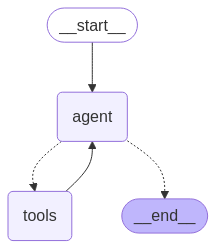

In [8]:
from langgraph.prebuilt import create_react_agent

system = """Ты полезный банковский ассистент, который помогает пользователю работать с картами банка.
Если пользователь просит заблокировать карту, обязательно уточни у него причину блокировки.
"""

agent = create_react_agent(giga, tools=[get_cards, block_card], checkpointer=MemorySaver(), prompt=system)
agent

In [9]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}

while True:
  query = input("User: ")
  if query == "" or query == "q":
    break
  print(f"User: {query}")
  resp = agent.invoke({"messages": [{"role": "human", "content": query}]}, config)
  print(f'Bot: {resp["messages"][-1].content}')
  time.sleep(0.5) # For corrent output in jupyter

User: Привет
Bot: Здравствуйте! Как я могу помочь вам сегодня?
User: Я потерял все свои карты
Bot: Сожалею это услышать. Я могу помочь Вам заблокировать Ваши карты для предотвращения несанкционированного использования. Могу ли я получить подтверждение, что Вы действительно хотите заблокировать все Ваши карты из-за их потери?
User: Да, давай блокируй все что есть
>>> called get_cards
Bot: У Вас есть две активные карты:
Карта МИР ****11824
Карта VISA ****14732

Вы уверены, что хотите заблокировать обе эти карты по причине утраты?
User: да
>>> called block_card(2202208XXXX11824, lost)
>>> called block_card(4508103XXXX14732, lost)
Bot: Все ваши карты были успешно заблокированы. Если вы планируете заказать новые карты или у вас возникли дополнительные вопросы, пожалуйста, сообщите мне об этом.


# Описание агентов (ролей)
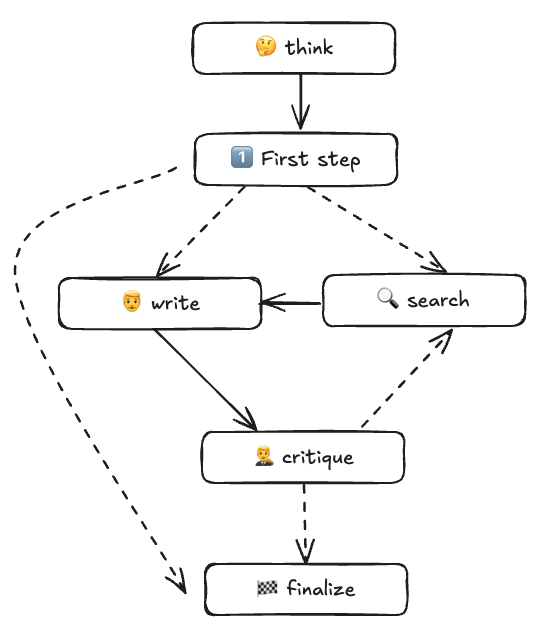

## Главное состояние графа (state)

Общая память для всех агентов. Здесь хранится история сообщений и другие данные, которые появляются в процессе работы.

- При старте агента он получает все эти данные (или их часть данных)
- После окончания работы агент может изменить поля стейта


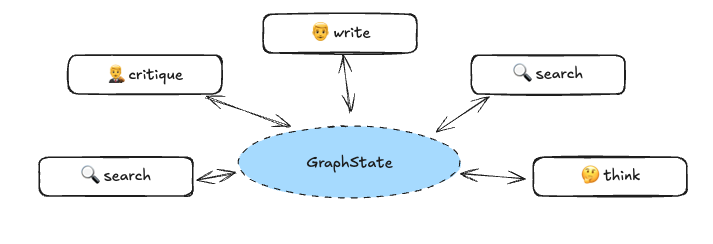

In [11]:
class ReasoningState(MessagesState):
  last_reason: str
  user_question: str
  last_answer: str
  critique: List[str]
  final_decision: str
  final_answer: str
  search_query: str
  search_results: Dict
  
MAIN_TEMPLATE = f"""Ты - ИИ Ассистент на базе GigaChat.
Твоя задача качественно ответить на вопрос пользователя.
Сегодняшняя дата - {time.strftime('%Y-%m-%d')}

"""

## Агент-ризонер

In [12]:
REASONER_TEMPLATE = MAIN_TEMPLATE + """Думай как аналитик, который обдумывает вопрос пользователя перед тем, как начать отвечать на него.
Напиши свои мысли о том, как ответить на вопрос пользователя.
Подумай, почему пользователь задает такой вопрос.
Как ты можешь ответить на него наилучшим образом?
Что именно нужно пользователю? Этот ли вопрос он на самом деле хотел задать? Напиши свои мысли по этим вопросам.
Учти, что у тебя будет возможность воспользоваться поиском в интернете, так что учитывай это при планировании. Но не ищи в интернете в ситуации, если ты сам знаешь ответ.

Вопрос пользователя - {user_question}
"""

def reason(state: ReasoningState):
    prompt = ChatPromptTemplate.from_messages([
        ("system", REASONER_TEMPLATE)
    ])

    chain = prompt | giga | StrOutputParser()

    res = chain.invoke(
        {
            "user_question": state['user_question'],
        }
    )

    return {"last_reason": res}

## Агент выбора первого шага

In [ ]:
class FirstStep(BaseModel):
    """Описание первого шага для ответа на вопрос пользователя"""
    search_query: str = Field(description="Текст поискового запроса на поиск данных в интернете, если нужен")
    final_decision: str = Field(description="Итоговое решение, должно быть одно из следующих: ")


FIRST_STEP_TEMPLATE = MAIN_TEMPLATE + """Думай как агент-координатор, который должен опредлить какой первый шаг нужно сделать для ответа на вопрос пользователя.
Ты должен выбрать, какой агент должен продолжить работу над вопросом пользователя.

Вопрос пользователя - {user_question}

Твои мысли по поводу вопроса пользователя:
<THINK>
{last_reason}
</THINK>

Выбрать нужно выбрать следующий шаг - какую функцию вызвать, чтобы ответить на вопрос пользователя наилучшим образом.
1. finalize - ответит агент-финализацтор, так как все данные для ответа на вопрос уже есть или вопрос простой и понятный и мы готовы ответить.
2. search - должен отработать агент-поисковик
3. writer - требуется работа агента-помошника, который напишет подробный ответ, который в дальнейшем будет проанализирован критиком.

Выведи только следующую информацию в формате JSON:
{format_instructions}"""


def first_step(state: ReasoningState) -> Command[Literal["🔍 search", "👨 write", "🏁 finalize"]]:
    parser = PydanticOutputParser(pydantic_object=FirstStep)
    prompt = ChatPromptTemplate.from_messages([
        ("system", FIRST_STEP_TEMPLATE)
    ]).partial(format_instructions=parser.get_format_instructions())

    chain = prompt | giga_lite | parser

    res = chain.invoke(
        {
            "user_question": state["user_question"],
            "last_reason": state["last_reason"],
        }
    )

    final_decision = res.final_decision
    search_query = res.search_query
    update = {"final_decision": final_decision, "search_query": search_query}
    goto = "🏁 finalize"

    if final_decision == "search" and search_query is not None and len(search_query) > 0:
        goto = "🔍 search"
    if final_decision == "writer":
        goto = "👨 write"

    return Command(
        update=update,
        goto=goto
    )

## Главный ассистент

In [14]:
ANSWER_TEMPLATE = MAIN_TEMPLATE + """Думай как агент-помощник пользователя.
Твоя задача - ответить на вопрос пользователя. Изучи свои предыдущие мысли и ответь пользователю на его вопрос с учетом своих мыслей.
Или, если требуется поиск, напиши, что нужно сначала вопспользоваться поиском, у тебя будет возмоность ответить после.

Вопрос пользователя - {user_question}

Твои мысли по поводу вопроса пользователя:
<THINK>
{last_reason}
</THINK>

Результаты поиска (если есть):
<SEARCH_RESULTS>
{search_results}
</SEARCH_RESULTS>

Теперь ответь пользователю:
"""

def answer(state: ReasoningState):
    prompt = ChatPromptTemplate.from_messages([
        ("system", ANSWER_TEMPLATE)
    ])

    chain = prompt | giga | StrOutputParser()

    res = chain.invoke(
        {
            "user_question": state["user_question"],
            "last_reason": state["last_reason"],
            "search_results": state.get("search_results", {})
        }
    )

    return {"last_answer": res}

## Агент-критик

In [15]:
class Critique(BaseModel):
    """Критика выступления"""

    thoughts: str = Field(description="Мысли по поводу ответа")
    critique: str = Field(description="Конструктивная критика ответа - что нужно поправить или доработать")
    search_query: str = Field(description="Текст поискового запроса на поиск данных в интернете, если нужен")
    final_decision: str = Field(description="Итоговое решение, должно быть одно из следующих: good (если нет новой критики, есть отрывки из книг и речь можно считать написаной), search (требуется поиск данных в интернете), fix (если требуется переписать или доработать ответ)")



CRITIQUE_TEMPLATE = MAIN_TEMPLATE + """Думай как агент-критик. Твоя задача - оценить ответ на вопрос пользователя и принять решение - что с ним делать.
Отвечать, переписать, запросить дополнительные данные у пользователя, запросить дополнительные данные в интернете.
Если для улучшения ответа нужен поиск в интернете - прими решение search и поиск в интернете будет выполнен.

Вопрос пользователя - {user_question}

Твои мысли по поводу вопроса пользователя:
<THINK>
{last_reason}
</THINK>

Предполагаемый ответ:
<LAST_ANSWER>
{last_answer}
</LAST_ANSWER>

Предыдущий набор критики, которую ты уже писал раньше (не повторяйся):
<OLD_CRITIQUE>
{old_critique}
</OLD_CRITIQUE>

Результаты поиска (если есть):
<SEARCH_RESULTS>
{search_results}
</SEARCH_RESULTS>

Выведи только следующую информацию в формате JSON:
{format_instructions}"""


def critique(state: ReasoningState) -> Command[Literal["🔍 search", "🏁 finalize", END]]:
    parser = PydanticOutputParser(pydantic_object=Critique)
    prompt = ChatPromptTemplate.from_messages([
        ("system", CRITIQUE_TEMPLATE)
    ]).partial(format_instructions=parser.get_format_instructions())

    chain = prompt | giga | parser

    res = chain.invoke(
        {
            "user_question": state["user_question"],
            "last_reason": state["last_reason"],
            "last_answer": state.get("last_answer", ""),
            "old_critique": state.get("critique", []),
            "search_results": state.get("search_results", {})
        }
    )

    final_decision = res.final_decision
    critique = res.critique
    search_query = res.search_query
    new_critique = state.get("critique", [])
    if new_critique is None:
        new_critique = []
    new_critique = new_critique.append(critique)


    update = {"final_decision": final_decision, "critique": new_critique, "search_query": search_query}
    goto = "🏁 finalize"

    if final_decision == "search" and search_query is not None and len(search_query) > 0:
        goto = "🔍 search"

    return Command(
        update=update,
        goto=goto
    )

## Агент-финализатор

In [17]:
FINALIZER_TEMPLATE = MAIN_TEMPLATE + """Думай как агент-выпускающий редактор.
Твоя задача - написать окончательный ответ с учетом критики и предыдущих ответов и размышлений.

Вопрос пользователя - {user_question}

Твои мысли по поводу вопроса пользователя:
<THINK>
{last_reason}
</THINK>

Первая версия предполагаемого ответа:
<LAST_ANSWER>
{last_answer}
</LAST_ANSWER>

Результаты поиска (если есть):
<SEARCH_RESULTS>
{search_results}
</SEARCH_RESULTS>

Критика этой версии ответа:
<CRITICUE>
{critique}
</CRITICUE>

Напиши финальную версию ответа пользователю (четко и ясно):
"""

def finalize(state: ReasoningState):
    prompt = ChatPromptTemplate.from_messages([
        ("system", FINALIZER_TEMPLATE)
    ])

    chain = prompt | giga | StrOutputParser()

    res = chain.invoke(
        {
            "user_question": state["user_question"],
            "last_reason": state["last_reason"],
            "critique": state.get("critique", ""),
            "last_answer": state.get("last_answer", ""),
            "search_results": state.get("search_results", {})
        }
    )

    return {"final_answer": res}

## Поисковик-скрапер

In [18]:
from tavily import TavilyClient

def search(state: ReasoningState):
    tavily_client = TavilyClient()
    response = tavily_client.search(state["search_query"])
    search_results = state.get("search_results", {})
    search_results[state["search_query"]] = response
    return {"search_results": search_results}

## Сборка графа

In [20]:
graph = StateGraph(ReasoningState)

graph.add_node("🤔 think", reason)
graph.add_node("1️⃣ First step", first_step)
graph.add_node("👨 write", answer)
graph.add_node("👨‍⚖️ critique", critique)
graph.add_node("🔍 search", search)
graph.add_node("🏁 finalize", finalize)

graph.add_edge(START, "🤔 think")
graph.add_edge("🤔 think", "1️⃣ First step")
graph.add_edge("👨 write", "👨‍⚖️ critique")
graph.add_edge("🔍 search", "👨 write")
graph.add_edge("🏁 finalize", END)



app = graph.compile()

# Запуск генерации

In [26]:
import uuid

inputs = {"user_question": "Что нового в модели GigaChat-2"}
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

start = time.time()
async for event in app.astream_events(inputs, version="v2"):
  event_type = event.get('event', None)
  agent = event.get('name', '')
  if agent in ["_write", "RunnableSequence", "__start__", "__end__", "LangGraph"]:
    continue
  if event_type == 'on_chat_model_stream':
    print(event['data']['chunk'].content, end='')
  elif event_type == 'on_chain_start':
    print(f"<{agent}>")
  elif event_type == 'on_chain_end':
    print(f"</{agent}>")
  # else:
   #print(event)

<🤔 think>
Пользователь хочет узнать о новых функциях или улучшениях, внесенных во вторую версию модели GigaChat (предположительно после версии, которую я представляю). Это типичный запрос, когда пользователи интересуются обновлениями технологий, особенно связанных с искусственным интеллектом и машинным обучением. Возможно, человек следит за развитием платформы и ищет конкретные изменения, такие как новые возможности обработки запросов, улучшение точности ответов, расширение функциональности и другие аспекты.

Для ответа на этот вопрос мне потребуется доступ к актуальной информации, поскольку данные, доступные мне сейчас, основаны на знаниях до определенного момента времени и не включают изменений, произошедших позже. В частности, учитывая сегодняшнюю дату — 2025 год, возможно, были значительные доработки модели GigaChat, которые могли повлиять на её функциональность и производительность.

Чтобы наиболее точно удовлетворить потребности пользователя, можно предложить следующие шаги:

1. 

# Подключение Arize Phoenix

In [ ]:
# !pip install arize-phoenix opentelemetry-exporter-otlp openinference-instrumentation-langchain -q


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [24]:
import phoenix as px
# session = px.launch_app(use_temp_dir=False) # Fo colab
session = px.launch_app()

/Users/knkrestnikov/Documents/giga/workshops/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [25]:
from phoenix.otel import register
from openinference.instrumentation.langchain import LangChainInstrumentor

tracer_provider = register(
  project_name="Agentic reasoning", # Default is 'default'
  endpoint="http://localhost:4317",
)

LangChainInstrumentor().instrument(tracer_provider=tracer_provider)

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: Agentic reasoning
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

